In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from collections import Counter
import cv2
import os
from matplotlib.patches import Rectangle

In [2]:
pwd

'/home/hkhachatrian/mae/jupyter_notebooks'

In [3]:
# annots = np.load('./annotations/f1m/224_8shot_shifts.npy', allow_pickle=True).item()
annots = np.load('/home/hkhachatrian/mae/annotations/f1m/224_8shot_shifts.npy', allow_pickle=True).item()

In [ ]:
!ls /mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/val1000

In [ ]:
with open('/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/val1000/fine_grained500.json') as f:
    full_annots = json.load(f)
# full_annots = np.load('./annotations/f1m/224_8shot_shifts.npy', allow_pickle=True).item()

In [ ]:
# full_annots['images']

## Patch/Pixel statistics

In [ ]:
def get_finegrained_class_patch_statistics(annotation_file):
    counts_common = Counter()
    counts_dinov2 = Counter()
    for anno in annotation_file['images']:
        counts_common.update(anno['patch_labels'])
        counts_dinov2.update(anno['patch_labels_16x16'])
        
    return counts_common, counts_dinov2

patch_counts, patch_counts_dinov2 = get_finegrained_class_patch_statistics(annots)

In [ ]:
def get_finegrained_class_pixel_statistics(annotation_file):
    count = Counter()
    for anno in annotation_file['images']:
        count.update(anno['black_image'].reshape(-1))
        
    return count

pixel_counts = get_finegrained_class_pixel_statistics(annots)

In [ ]:
pixel_counts[0]

In [ ]:
# for cat in annots['categories']:
#     print(pixel_counts[cat['id']])

In [ ]:
# annots['categories']

In [ ]:
# for cat in annots['categories']:
#     print(cat['name'])

In [ ]:
superclasses = ['bg', 'airplane', 'ship', 'car', 'court', 'road']

In [ ]:
finegrained_to_superclass = np.zeros(39, dtype=np.int32)
for i in range(1, 13):
    finegrained_to_superclass[i] = 1
for i in range(13, 22):
    finegrained_to_superclass[i] = 2
for i in range(22, 32):
    finegrained_to_superclass[i] = 3
for i in range(32, 36):
    finegrained_to_superclass[i] = 4
for i in range(36, 39):
    finegrained_to_superclass[i] = 5

In [ ]:
patch_counts_sup = np.zeros(6, dtype=np.int64)
patch_counts_sup_dinov2 = np.zeros(6, dtype=np.int64)
pixel_counts_sup = np.zeros(6, dtype=np.int64)

for key in patch_counts:
    patch_counts_sup[finegrained_to_superclass[key]] += patch_counts[key]
    
for key in patch_counts_dinov2:
    patch_counts_sup_dinov2[finegrained_to_superclass[key]] += patch_counts_dinov2[key]
    
for key in pixel_counts:
    pixel_counts_sup[finegrained_to_superclass[key]] += pixel_counts[key]

In [ ]:
pixel_counts_sup

In [ ]:
patch_counts_sup_dinov2

In [ ]:
patch_counts_sup

In [ ]:
annots['images'][1]

## Zoom-in/Zoom-out f1m images

In [4]:
cropped_img_name = annots['images'][0]['file_name']
cropped_img_path = './images/f1m/224_8shot/train/' + cropped_img_name

tile, y, x = [int(i) for i in cropped_img_name.split('.')[1].split('_')]

img_name = '.'.join([cropped_img_name.split('.')[0], cropped_img_name.split('.')[-1]]) 
img_path = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/val1000/images/' + img_name

In [5]:
print(tile, y, x)

224 2 1


In [6]:
cropped_img_path

'./images/f1m/224_8shot/train/5961__1__0___0.224_2_1.png'

In [11]:
def img_to_coord(tile, x, y):
    x1, y1 = x * tile, y * tile
    x2, y2 = (x+1) * tile, (y+1) * tile
    
    return np.array([x1, y1, x2, y2])


def get_scaled_coords(box_coords, scale_factor):
    
#     box_coords = np.array([x1, y1, x2, y2])
#     scale_factor = 1/2

    # Compute the dimensions of the box
    width = box_coords[2] - box_coords[0]
    height = box_coords[3] - box_coords[1]

    # Compute the new dimensions of the box based on the scale factor
    new_width = int(np.round(np.sqrt(scale_factor) * width))
    new_height = int(np.round(np.sqrt(scale_factor) * height))

    # Compute the coordinates of the new box
    new_xmin = int(np.round(box_coords[0] - (new_width - width) / 2))
    new_ymin = int(np.round(box_coords[1] - (new_height - height) / 2))
    new_xmax = new_xmin + new_width
    new_ymax = new_ymin + new_height
    
    if new_xmin < 0:
        new_xmax -= new_xmin
        new_xmin = 0
    if new_ymin < 0:
        new_ymax -= new_ymin
        new_ymin = 0
    # Store the new coordinates in a NumPy array
    new_box_coords = np.array([new_xmin, new_ymin, new_xmax, new_ymax])
    
    return new_box_coords


def plot_img_with_box(img, box_coords):
    fig, ax = plt.subplots()
    plt.imshow(img)
    if box_coords.size == 4:
        x_min, y_min, x_max, y_max = box_coords
        
        # box_coords = np.array([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])
    else:
        x_max, y_max, x_min, y_min = np.array([box_coords[0][0], box_coords[0][1], 
                                               box_coords[2][0], box_coords[2][1]])
        
    width = x_max - x_min
    height = y_max - y_min
    rect = Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    # x, y = zip(*box_coords)
    # plt.plot(x, y, color='red')
    
    ax.add_patch(rect)
    plt.show()
    
    
def get_new_crop(img, box, resize=False, tile=224):
    if box.size != 4:
        box = np.array([box[0][0], box[0][1], box[2][0], box[2][1]])
        
    new_img = img[box[1]:box[3], box[0]:box[2], :]
    
    if resize:
        new_img = cv2.resize(new_img, (tile, tile), interpolation=cv2.INTER_CUBIC)
        
    return new_img

def get_patch_by_index(idx, w=14, tileHW=16):
    y = idx // w
    x = idx % w
    return img_to_coord(tileHW, x, y)

def scale_full_image(img, scale_factor):
    width, height = img.shape[:2]
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    resized_image = cv2.resize(img, (new_width, new_height))
    return resized_image

In [8]:
cropped_img_name = annots['images'][0]['file_name']
cropped_img_path = './images/f1m/224_8shot/train/' + cropped_img_name

tile, tile_y, tile_x = [int(i) for i in cropped_img_name.split('.')[1].split('_')]
patch_hw = 16
ret_img_hw = tile 
patchNumbHV = ret_img_hw // patch_hw


img_name = '.'.join([cropped_img_name.split('.')[0], cropped_img_name.split('.')[-1]]) 
img_path = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/val1000/images/' + img_name

In [9]:
print(cropped_img_name)

5961__1__0___0.224_2_1.png


In [32]:
# scale_factor = 1.1

# img = cv2.imread(img_path)
# width, height = img.shape[:2]

# img_center_x, img_center_y = width//2, height // 2

# center_tile_x, center_tile_y = tile_x*tile + tile // 2, tile_y*tile + tile // 2


# scaled_img_center_x, scaled_img_center_y = int(scale_factor * img_center_x), int(scale_factor * img_center_y)

# # print(img_center_x, img_center_y, center_tile_x, center_tile_y)

# scaled_center_tile_x, scaled_center_tile_y = int(scale_factor * center_tile_x), int(scale_factor * center_tile_y)
# # print(scaled_img_center_x, scaled_img_center_y, scaled_center_tile_x, scaled_center_tile_y)


# start_orig_x = int(center_tile_x - (tile / 2))
# start_orig_y = int(center_tile_y - (tile / 2))

# end_orig_x = int(start_orig_x + tile)
# end_orig_y = int(start_orig_y + tile)

# print(start_orig_x, start_orig_y, end_orig_x, end_orig_y)

# # Calculate the coordinates of the top-left corner of the new crop
# start_scaled_x = int(scaled_center_tile_x - (tile / 2))
# start_scaled_y = int(scaled_center_tile_y - (tile / 2))

# end_scaled_x = int(start_scaled_x + tile)
# end_scaled_y = int(start_scaled_y + tile)

# print(start_scaled_x, start_scaled_y, end_scaled_x, end_scaled_y)


# scaled_centers_patches = get_patch_center_coordinates_subimage([start_scaled_x, start_scaled_y], [end_scaled_x, end_scaled_y], tile, patch_hw)

# orig_image_mapped_center = [[int(cur_center_x/scale_factor), int(cur_center_y/scale_factor)] for cur_center_x, cur_center_y in scaled_centers_patches]

# correspondence_vec = [-1 for _ in range(len(orig_image_mapped_center))]
# for i in range(len(orig_image_mapped_center)):
#     if orig_image_mapped_center[i][0] - start_orig_x >= 0 and orig_image_mapped_center[i][0] < end_orig_x \
#     and orig_image_mapped_center[i][1] - start_orig_y >= 0 and orig_image_mapped_center[i][1] < end_orig_y:
#         correspondence_vec[patchNumbHV*((orig_image_mapped_center[i][1] - start_orig_y)//patch_hw) + ((orig_image_mapped_center[i][0] - start_orig_x) // patch_hw)] = i

224 448 448 672
257 504 481 728


In [35]:
def get_resized_tile(full_img, tile_x, tile_y, scale_factor, tile=224, patch_hw=16):
    
    img = full_img.copy()
    width, height = img.shape[:2]
    img_center_x, img_center_y = width//2, height // 2
    patchNumbHV = tile // patch_hw
    
    center_tile_x, center_tile_y = tile_x*tile + tile // 2, tile_y*tile + tile // 2
    
    scaled_img_center_x, scaled_img_center_y = int(scale_factor * img_center_x), int(scale_factor * img_center_y)
    scaled_center_tile_x, scaled_center_tile_y = int(scale_factor * center_tile_x), int(scale_factor * center_tile_y)

#     Calulate the coordinates of the top-left and bottom-right corner of the original tile
    start_orig_x, start_orig_y = int(center_tile_x - (tile / 2)),int(center_tile_y - (tile / 2))
    end_orig_x, end_orig_y = int(start_orig_x + tile), int(start_orig_y + tile)

# #     Calculate the coordinates of the top-left and bottom-right corner of the resized tile
#     start_scaled_x, start_scaled_y = int(scaled_center_tile_x - (tile / 2)),int(scaled_center_tile_y - (tile / 2))
#     end_scaled_x, end_scaled_y = int(start_scaled_x + tile), int(start_scaled_y + tile)
    
    start_scaled_x = max(0, int(scaled_center_tile_x - (tile / 2)))
    start_scaled_y = max(0, int(scaled_center_tile_y - (tile / 2)))
    end_scaled_x = int(start_scaled_x + tile)
    end_scaled_y = int(start_scaled_y + tile)
    if end_scaled_y >= 1000:
        start_scaled_y = 1000 - tile
        end_scaled_y = 1000
    if end_scaled_x >= 1000:
        start_scaled_x = 1000 - tile
        end_scaled_x = 1000
    
    scaled_centers_patches = get_patch_center_coordinates_subimage([start_scaled_x, start_scaled_y], [end_scaled_x, end_scaled_y], tile, patch_hw)
    orig_image_mapped_center = [[int(cur_center_x/scale_factor), int(cur_center_y/scale_factor)] for cur_center_x, cur_center_y in scaled_centers_patches]

    correspondence_vec = [-1 for _ in range(len(orig_image_mapped_center))]
    for i in range(len(orig_image_mapped_center)):
        if orig_image_mapped_center[i][0] - start_orig_x >= 0 and orig_image_mapped_center[i][0] < end_orig_x \
        and orig_image_mapped_center[i][1] - start_orig_y >= 0 and orig_image_mapped_center[i][1] < end_orig_y:
#             correspondence_vec[patchNumbHV*((orig_image_mapped_center[i][1] - start_orig_y)//patch_hw) + ((orig_image_mapped_center[i][0] - start_orig_x) // patch_hw)] = i
            correspondence_vec[i] = patchNumbHV*((orig_image_mapped_center[i][1] - start_orig_y)//patch_hw) + ((orig_image_mapped_center[i][0] - start_orig_x) // patch_hw)
            
    resized_img = scale_full_image(img, scale_factor)

    return resized_img, resized_img[start_scaled_y:end_scaled_y, start_scaled_x:end_scaled_x], correspondence_vec


In [36]:
annots = np.load('../annotations/f1m/224_8shot_shifts.npy', allow_pickle=True).item()

In [37]:
def img_properties(file_name):
    tile, y, x = [int(i) for i in file_name.split('.')[1].split('_')]
    
    img_name = '.'.join([file_name.split('.')[0], file_name.split('.')[-1]]) 
    
    return img_name, tile, x, y

In [47]:
scale_factor = 1.1 # 0.8 0.9 1.1 1.2 # [5, 10, 15, 20]
sf = str(scale_factor).replace('.', '_')
scaled_annots = {'images': [], 'categories': annots['categories']}
saving_path = f'/home/hkhachatrian/mae/images/f1m/224_8shot_scale_{sf}/'

for annot in tqdm(annots['images'], total=len(annots['images'])):
    intermediate_dct = {}    
    
    tiled_img_name = annot['file_name']
    tiled_img_path = '../images/f1m/224_8shot/train/' + tiled_img_name
    
    img_name, tile_size, idx, idy = img_properties(tiled_img_name)
    
    img_path = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/val1000/images/' + img_name
    black_img_path = '/home/hkhachatrian/mae/images/f1m/fine_grain_500/gt/' + img_name
    
    img = cv2.imread(img_path)
    black_img = cv2.imread(black_img_path)
    
    if img is None or black_img is None:
        print('no file name found')
        print(img_path)
        break
        
    # Get rotated tiled image and save, add file name to annotation file
    
    cropped_img, scaled_tiled_img, map_vector = get_resized_tile(full_img=img, tile_x=idx, tile_y=idy, \
                                                     scale_factor=scale_factor, patch_hw=16)
    
    _, _, map_vector_14 = get_resized_tile(full_img=img, tile_x=idx, tile_y=idy, \
                                        scale_factor=scale_factor, patch_hw=14)
    
#     print(saving_path, tiled_img_name, scaled_tiled_img)
    assert scaled_tiled_img.size == 224 * 224 * 3, 'size is not correct'
    cv2.imwrite(os.path.join(saving_path, tiled_img_name), scaled_tiled_img)
    
    intermediate_dct['file_name'] = os.path.join(saving_path, tiled_img_name)
    intermediate_dct['height'] = annot['height']
    intermediate_dct['width'] = annot['width']
    intermediate_dct['id'] = annot['id']
    
    
    # Get tiled black image, add to dictionary
    
    _, scaled_tiled_black_img, _ = get_resized_tile(full_img=black_img, tile_x=idx, tile_y=idy, \
                                                  scale_factor=scale_factor, patch_hw=16)
    scaled_tiled_black_img = scaled_tiled_black_img[:, :, 0]
    
#     print('shape of black img:', rotated_tiled_black_img.shape, rotated_tiled_black_img[0].shape )
    intermediate_dct['black_image'] = scaled_tiled_black_img
    
    # calculate patch labels
    
    patch_labels = cv2.resize(scaled_tiled_black_img, (14, 14), interpolation=cv2.INTER_NEAREST_EXACT)
    patch_labels_16x16 = cv2.resize(scaled_tiled_black_img, (16, 16), interpolation=cv2.INTER_NEAREST_EXACT)
    
    intermediate_dct['patch_labels'] = patch_labels.reshape(-1)
    intermediate_dct['patch_labels_16x16'] = patch_labels_16x16.reshape(-1)
    
    intermediate_dct['map_from_scale_to_original_idx'] = np.array(map_vector)
    intermediate_dct['map_from_scale_to_original_idx_16'] = np.array(map_vector_14)
    
    scaled_annots['images'].append(intermediate_dct)

np.save(f'../annotations/f1m/224_8shot_scale_{sf}.npy', scaled_annots)

  0%|          | 0/295 [00:00<?, ?it/s]

In [45]:
!ls ../annotations/f1m/

224_8shot_blur2.npy	224_8shot_rotate_10.npy  224_8shot_shifts.npy
224_8shot_blur4.npy	224_8shot_rotate_15.npy  250_16shot_train.npy
224_8shot_blur6.npy	224_8shot_rotate_20.npy  250_16shot_val.npy
224_8shot_blur8.npy	224_8shot_rotate_5.npy	 250_32shot_train.npy
224_8shot_noise_10.npy	224_8shot_scale_0_8.npy  250_32shot_val.npy
224_8shot_noise_20.npy	224_8shot_scale_0_9.npy  250_8shot_train.npy
224_8shot_noise_30.npy	224_8shot_scale_1_1.npy  250_8shot_val.npy
224_8shot_noise_40.npy	224_8shot_scale_1_2.npy


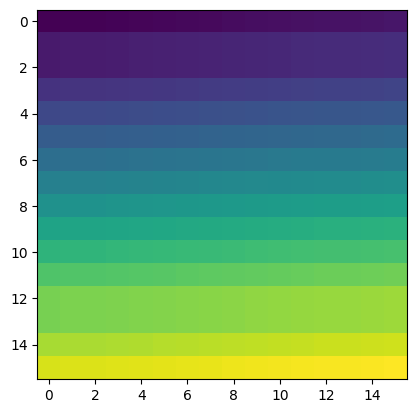

In [48]:
plt.imshow(np.array(map_vector_14).reshape(16, 16)); 

In [62]:
for scale in ['0_8', '0_9', '1_1', '1_2']:
    
    tmp = np.load(f'../annotations/f1m/224_8shot_scale_{scale}.npy', allow_pickle=True).item()
    idx = []
    idx_16 = []
    for ann in tmp['images']:
        idx.append(ann['map_from_scale_to_original_idx'])
        idx_16.append(ann['map_from_scale_to_original_idx_16'])

    idx = np.concatenate(idx)
    idx_16 = np.concatenate(idx_16)

    for model in ['mae', 'dino', 'mae_200', 'sup_vit', 'simmim']:
        np.save(f'../embeddings/fair1m/{model}_224_8shot_map_from_scale_{scale}_to_original_idx.npy',\
                idx, allow_pickle=True)

    np.save(f'../embeddings/fair1m/dinov2_224_8shot_map_from_scale_{scale}_to_original_idx.npy',\
            idx_16, allow_pickle=True)

In [32]:
img = cv2.imread(img_path)
scale_factor = 1.2

cpnd, res_img = get_resized_tile(img, tile_x, tile_y, scale_factor, tile, patch_hw)

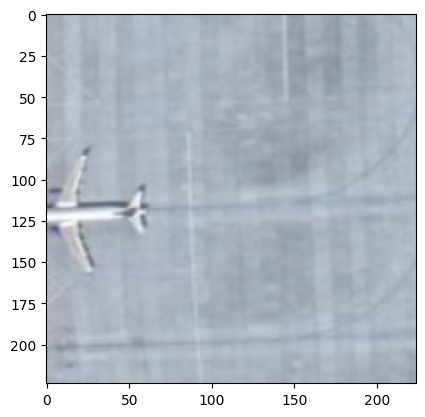

In [33]:
plt.imshow(res_img)

In [34]:
np.unique(np.array(cpnd), return_counts=True)

(array([ -1,   0,   1,   2,   4,   5,   6,   7,   8,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,
         29,  30,  32,  33,  34,  35,  36,  38,  39,  40,  41,  56,  57,
         58,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  71,  72,
         74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  88,
         89,  90,  91,  92,  94,  95,  96,  97,  98,  99, 100, 102, 103,
        104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118,
        119, 120, 122, 123, 124, 125, 140, 141, 142, 144, 145, 146, 147,
        148, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162,
        164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 178,
        179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 192, 193,
        194, 195]),
 array([52,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  

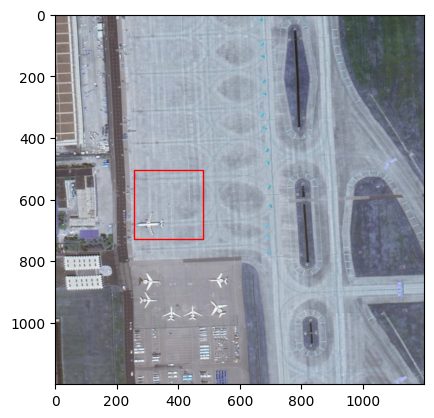

In [87]:
newImg = scale_full_image(img, scale_factor)
newImg = draw_red_crosses(newImg, [[scaled_center_tile_x, scaled_center_tile_y]])
plot_img_with_box(newImg, np.array([start_scaled_x, start_scaled_y, end_scaled_x, end_scaled_y]))

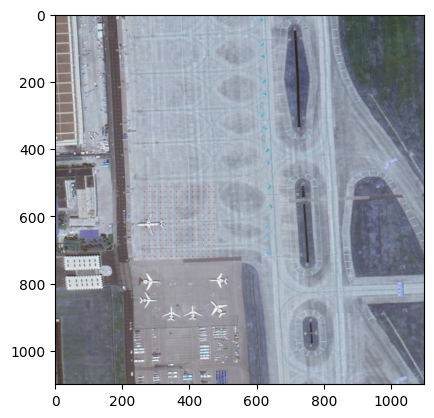

In [35]:
img_dr_red_scaled = draw_red_crosses(newImg, scaled_centers_patches)
plt.imshow(img_dr_red_scaled)

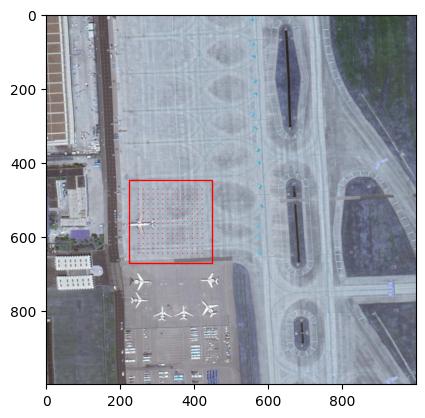

In [88]:
img_dr_red = draw_red_crosses(img, orig_image_mapped_center)
plot_img_with_box(img_dr_red, np.array([start_orig_x, start_orig_y, end_orig_x, end_orig_y]))

In [56]:
scale_factor

0.8

In [ ]:
# newImg = scale_full_image(img, scale_factor)
# plt.imshow(newImg)

In [ ]:
print(y)

In [ ]:
box_coords = img_to_coord(tile, x, y)

img = cv2.imread(img_path)
cropped_img = cv2.imread(cropped_img_path)

In [ ]:
plot_img_with_box(img, box_coords)

In [ ]:
scale_factor = 1/2
new_box_coords = get_scaled_coords(box_coords, scale_factor)
zoom_in_img = get_new_crop(img, new_box_coords, resize=True, tile=tile) 
plot_img_with_box(img, new_box_coords)

In [ ]:
scale_factor = 2
new_box_coords = get_scaled_coords(box_coords, scale_factor)
zoom_out_img = get_new_crop(img, new_box_coords, resize=True, tile=tile) 
plot_img_with_box(img, new_box_coords)

In [ ]:
fix, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 4))
ax[0].imshow(zoom_out_img)
ax[0].set_title('zoom out image')
ax[1].imshow(cropped_img)
ax[1].set_title('original image')
ax[2].imshow(zoom_in_img)
ax[2].set_title('zoom in image')
plt.show()

## Rotate image

In [49]:
def rotation_matrix(angle, width, height):
    # Specify the center of rotation (in pixels)
    cx, cy = width / 2, height / 2
    
    # Create a transformation matrix for rotating the image around the specified center
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1)
    
    # Compute the size of the new image to contain all of the rotated image
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))

    # Adjust the transformation matrix to shift the center of rotation to the specified point
    M[0, 2] += (new_width / 2) - cx
    M[1, 2] += (new_height / 2) - cy
    
    return M


def rotate_image(img, M, rotate_box=None):
    height, width = img.shape[:2]
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))
    
#     new_height, new_width = np.dot(M, [height, width, 1])[:2]
    
#     print(new_height, new_width)
    size = max(int(new_height), int(new_width))
    rotated_img = cv2.warpAffine(img, M, (size, size))
    
    if isinstance(rotate_box, np.ndarray):
    
        # Rotate the corner points of the bounding box using the transformation matrix
        rotated_bbox = []

        # Define the bounding box as a list of (x, y) coordinates
        # rotate_box = np.array([x1, y1, x2, y2])

        bbox = np.array([(rotate_box[0], rotate_box[1]),     # (x1, y1)
                (rotate_box[0], rotate_box[3]),     # (x1, y2)
                (rotate_box[2], rotate_box[3]),     # (x2, y2)
                (rotate_box[2], rotate_box[1])])     # (x2, y1)

        for x, y in bbox:
            new_x, new_y = np.dot(M, [x, y, 1])[:2]
            rotated_bbox.append((new_x, new_y))
#         rotated_bbox = apply_affine_transform(bbox, M)

        rotated_bbox = np.array(rotated_bbox, dtype=np.int32) # [(x1, y1), ]
        rotated_coords = np.array([rotated_bbox[0][0], rotated_bbox[0][1], rotated_bbox[2][0], rotated_bbox[2][1]])
        
        return rotated_img, rotated_bbox
    
    return rotated_img


def split_image_into_patches(image, d):
    # Convert the image to a NumPy array
    image_array = np.array(image)
    
    # Get the dimensions of the image
    width, height, _ = image_array.shape
    
    # Calculate the number of patches in the horizontal and vertical directions
    num_patches_horizontal = width // d
    num_patches_vertical = height // d
    
    # Create a grid of coordinates for the patches
    x_coords = np.arange(num_patches_horizontal) * d + d // 2
    y_coords = np.arange(num_patches_vertical) * d + d // 2
    patch_centers = np.transpose([np.tile(x_coords, len(y_coords)), np.repeat(y_coords, len(x_coords))])
    
    return patch_centers



def get_patch_center_coordinates_subimage(top_left, bottom_right, lenWH, d):
    centers = []

    for i in range(lenWH//d):
        for j in range(lenWH//d):
            cell_center_x = top_left[0] + (j * d) + (d // 2)
            cell_center_y = top_left[1] + (i * d) + (d // 2)
            centers.append((cell_center_x, cell_center_y))
    return centers


def get_patch_center_coordinates(height, width, d):

    
    # Calculate the number of patches in the horizontal and vertical directions
    num_patches_horizontal = width // d
    num_patches_vertical = height // d
    
    # Create a grid of coordinates for the patches
    x_coords = np.arange(num_patches_horizontal) * d + d // 2
    y_coords = np.arange(num_patches_vertical) * d + d // 2
    patch_centers = np.transpose([np.tile(x_coords, len(y_coords)), np.repeat(y_coords, len(x_coords))])
    
    return patch_centers

def apply_affine_transform(points, M):
    # Convert the points to a NumPy array
    points_array = np.array(points)
    
    # Add an extra dimension to the points array
    points_array = np.expand_dims(points_array, axis=1)
    
    # Apply the affine transformation
    transformed_points = cv2.transform(points_array, M)
    
    # Remove the extra dimension from the transformed points array
    transformed_points = np.squeeze(transformed_points, axis=1)
    
    return transformed_points.tolist()

def apply_shift_transform(points, shift_x, shift_y):
    
    subtracted_points = [(x - shift_x, y - shift_y) for (x, y) in points]
    
    return subtracted_points
    

def draw_red_crosses(image, points):
    
    # Convert the image to a NumPy array
    image_array = np.array(image)
    
    # Draw red crosses on the image for each point
    for point in points:
        
        # Extract the x and y coordinates of the point
        x, y = point
        
        # Draw two red lines to form a cross
        cv2.line(image_array, (x - 1, y - 1), (x + 1, y + 1), (255, 0, 0), 1)
        cv2.line(image_array, (x + 1, y - 1), (x - 1, y + 1), (255, 0, 0), 1)
        
    # Convert the NumPy array back to an image
#     result_image = Image.fromarray(image_array)
    
    return image_array



# Crop the image,for the given center and by given height and width

def central_crop(image, center_x, center_y, new_width, new_height):
    
    height, width = image.shape[:2]

    # Calculate the coordinates of the top-left corner of the new crop
    start_x = int(center_x - (new_width / 2))
    start_y = int(center_y - (new_height / 2))

    # Calculate the coordinates of the bottom-right corner of the new crop
    end_x = int(start_x + new_width)
    end_y = int(start_y + new_height)

    # Perform the crop
    cropped_image = image[start_y:end_y, start_x:end_x]

    return cropped_image

def get_center(x, y, tile_size):
    return np.array([[x * tile_size + tile_size//2, y * tile_size + tile_size//2]])
    

In [50]:
angle = 20
centers = split_image_into_patches(img, 16)
M = rotation_matrix(angle, *img.shape[:2])

new_centers = apply_affine_transform(centers, M)
rotated_img, box = rotate_image(img, M, box_coords)

NameError: name 'box_coords' is not defined

In [ ]:
print(img.shape[0])

In [ ]:
plot_img_with_box(rotated_img, box)

In [ ]:
rotated_img.shape[0] // 2, rotated_img.shape[1] // 2

In [ ]:
center_x, center_y = rotated_img.shape[0] // 2, rotated_img.shape[1] // 2
new_width, new_height = img.shape[0], img.shape[1]
start_x = int(center_x - (new_width / 2))
start_y = int(center_y - (new_height / 2))


cropped_img = central_crop(rotated_img, center_x, center_y, new_width, new_height)


new_centers = apply_affine_transform(centers, M)
new_centers = apply_shift_transform(new_centers, start_x, start_y)



In [ ]:
cent_coord = get_center(x, y, 224)

print(centers.shape)


new_center_coord = apply_affine_transform(cent_coord, M)
new_center_coord = apply_shift_transform(new_center_coord, start_x, start_y)

print(cent_coord)
print(new_center_coord)

In [ ]:
new_width, new_height = 224, 224

start_x = int(new_center_coord[0][0] - (new_width / 2))
start_y = int(new_center_coord[0][1] - (new_height / 2))

# Calculate the coordinates of the bottom-right corner of the new crop
end_x = int(start_x + new_width)
end_y = int(start_y + new_height)


In [ ]:
final_box = np.array([[start_x, start_y], [start_x, end_y], [end_x, end_y], [end_x, start_y]])

In [ ]:
plot_img_with_box(cropped_img, final_box)

In [ ]:
print(final_box)

In [ ]:
# def get_rotated_tile(full_img, tile_x, tile_y, rotation_angle, ret_img_hw=224):
    
#     M = rotation_matrix(angle, *img.shape[:2])
    
#     rotated_img = rotate_image(full_img, M)
    
#     center_x, center_y = rotated_img.shape[0] // 2, rotated_img.shape[1] // 2
#     new_width, new_height = img.shape[0], img.shape[1]
    
#     start_x, start_y = int(center_x - (new_width / 2)), int(center_y - (new_height / 2))

#     cropped_img = central_crop(rotated_img, center_x, center_y, new_width, new_height)
    
#     cent_coord = get_center(tile_x, tile_y, ret_img_hw)

#     new_center_coord = apply_affine_transform(cent_coord, M)
#     new_center_coord = apply_shift_transform(new_center_coord, start_x, start_y)

#     crop_start_x = int(new_center_coord[0][0] - (ret_img_hw / 2))
#     crop_start_y = int(new_center_coord[0][1] - (ret_img_hw / 2))
#     crop_end_x = int(crop_start_x + ret_img_hw)
#     crop_end_y = int(crop_start_y + ret_img_hw)

#     return cropped_img[crop_start_y:crop_end_y, crop_start_x:crop_end_x], (crop_start_x, crop_start_y)

In [51]:
def get_rotated_tile(full_img, tile_x, tile_y, rotation_angle, ret_img_hw=224, patch_hw=16):
    
    patchNumbHV = ret_img_hw // patch_hw
    
    M = rotation_matrix(rotation_angle, *img.shape[:2])
    
    rotated_img = rotate_image(full_img, M)
    
    center_x, center_y = rotated_img.shape[0] // 2, rotated_img.shape[1] // 2
    new_width, new_height = img.shape[0], img.shape[1]
    
    start_x, start_y = int(center_x - (new_width / 2)), int(center_y - (new_height / 2))

    cropped_img = central_crop(rotated_img, center_x, center_y, new_width, new_height)

    cent_coord = get_center(tile_x, tile_y, ret_img_hw)

    new_center_coord = apply_affine_transform(cent_coord, M)
    new_center_coord = apply_shift_transform(new_center_coord, start_x, start_y)

    crop_start_x = max(0, int(new_center_coord[0][0] - (ret_img_hw / 2)))
    crop_start_y = max(0, int(new_center_coord[0][1] - (ret_img_hw / 2)))
    crop_end_x = int(crop_start_x + ret_img_hw)
    crop_end_y = int(crop_start_y + ret_img_hw)
    if crop_end_y >= 1000:
        crop_start_y = 1000 - ret_img_hw
        crop_end_y = 1000
    if crop_end_x >= 1000:
        crop_start_x = 1000 - ret_img_hw
        crop_end_x = 1000
    #     Find correspondences between patches of original and rotated patches
    old_centers_patches = get_patch_center_coordinates_subimage([tile_x*ret_img_hw, tile_y*ret_img_hw], [(tile_x+1)*ret_img_hw, (tile_y+1)*ret_img_hw], ret_img_hw, patch_hw)

    new_centers_patches = apply_affine_transform(old_centers_patches, M)
    new_centers_patches = apply_shift_transform(new_centers_patches, start_x, start_y)
    
    correspondence_vec = [-1 for _ in range(len(new_centers_patches))]
    for i in range(len(new_centers_patches)):
        if new_centers_patches[i][0] - crop_start_x >= 0 and \
        new_centers_patches[i][0] - crop_start_x < ret_img_hw and new_centers_patches[i][1] - crop_start_y >= 0 and \
        new_centers_patches[i][1] - crop_start_y < ret_img_hw:
#             correspondence_vec[patchNumbHV*((new_centers_patches[i][1] - crop_start_y)//patch_hw) + ((new_centers_patches[i][0] - crop_start_x) // patch_hw)] = i
            correspondence_vec[i] = patchNumbHV*((new_centers_patches[i][1] - crop_start_y)//patch_hw) + ((new_centers_patches[i][0] - crop_start_x) // patch_hw)
#     print(crop_start_y, crop_end_y, ':', crop_start_x, crop_end_x)
    return cropped_img, cropped_img[crop_start_y:crop_end_y, crop_start_x:crop_end_x], correspondence_vec


## Create dataset

In [53]:
annots = np.load('../annotations/f1m/224_8shot_shifts.npy', allow_pickle=True).item()

In [54]:
def img_properties(file_name):
    tile, y, x = [int(i) for i in file_name.split('.')[1].split('_')]
    
    img_name = '.'.join([file_name.split('.')[0], file_name.split('.')[-1]]) 
    
    return img_name, tile, x, y

In [83]:
angle = 5 # [5, 10, 15, 20]
rotated_annots = {'images': [], 'categories': annots['categories']}
saving_path = f'/home/hkhachatrian/mae/images/f1m/224_8shot_rotate_{angle}/'

for annot in tqdm(annots['images'], total=len(annots['images'])):
    intermediate_dct = {}    
    
    tiled_img_name = annot['file_name']
    tiled_img_path = './images/f1m/224_8shot/train/' + tiled_img_name
    
    img_name, tile_size, idx, idy = img_properties(tiled_img_name)
    
    img_path = '/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/val1000/images/' + img_name
    black_img_path = '/home/hkhachatrian/mae/images/f1m/fine_grain_500/gt/' + img_name
    
    img = cv2.imread(img_path)
    black_img = cv2.imread(black_img_path)
    
    if img is None or black_img is None:
        print('no file name found')
        print(img_path)
        break
        
    # Get rotated tiled image and save, add file name to annotation file
    
    cropped_img, rotated_tiled_img, map_vector = get_rotated_tile(full_img=img, tile_x=idx, tile_y=idy, \
                                                     rotation_angle=angle, patch_hw=16)
    
    _, _, map_vector_14 = get_rotated_tile(full_img=img, tile_x=idx, tile_y=idy, \
                                        rotation_angle=angle, patch_hw=14)
    
#     print(saving_path, tiled_img_name, rotated_tiled_img)
    assert rotated_tiled_img.size == 224 * 224 * 3, 'size is not correct'
#     cv2.imwrite(os.path.join(saving_path, tiled_img_name), rotated_tiled_img)
    
    intermediate_dct['file_name'] = os.path.join(saving_path, tiled_img_name)
    intermediate_dct['height'] = annot['height']
    intermediate_dct['width'] = annot['width']
    intermediate_dct['id'] = annot['id']
    
    
    # Get tiled black image, add to dictionary
    
    _, rotated_tiled_black_img, _ = get_rotated_tile(full_img=black_img, tile_x=idx, tile_y=idy, \
                                                  rotation_angle=angle, patch_hw=16)
    rotated_tiled_black_img = rotated_tiled_black_img[:, :, 0]
    
#     print('shape of black img:', rotated_tiled_black_img.shape, rotated_tiled_black_img[0].shape )
    intermediate_dct['black_image'] = rotated_tiled_black_img
    
    # calculate patch labels
    
    patch_labels = cv2.resize(rotated_tiled_black_img, (14, 14), interpolation=cv2.INTER_NEAREST_EXACT)
    patch_labels_16x16 = cv2.resize(rotated_tiled_black_img, (16, 16), interpolation=cv2.INTER_NEAREST_EXACT)
    
    intermediate_dct['patch_labels'] = patch_labels.reshape(-1)
    intermediate_dct['patch_labels_16x16'] = patch_labels_16x16.reshape(-1)
    
    intermediate_dct['map_from_rotated_to_original_idx'] = map_vector
    intermediate_dct['map_from_rotated_to_original_idx_16'] = map_vector_14
    
    rotated_annots['images'].append(intermediate_dct)

np.save(f'../annotations/f1m/224_8shot_rotate_{angle}.npy', rotated_annots)

  0%|          | 0/295 [00:00<?, ?it/s]

In [84]:
!ls ../annotations/f1m/ | grep rotate

224_8shot_rotate_10.npy
224_8shot_rotate_15.npy
224_8shot_rotate_20.npy
224_8shot_rotate_5.npy


In [86]:
for rot in [5, 10, 15, 20]:
    
    tmp = np.load(f'../annotations/f1m/224_8shot_rotate_{rot}.npy', allow_pickle=True).item()
    idx = []
    idx_16 = []
    for ann in tmp['images']:
        idx.append(ann['map_from_rotated_to_original_idx'])
        idx_16.append(ann['map_from_rotated_to_original_idx_16'])

    idx = np.concatenate(idx)
    idx_16 = np.concatenate(idx_16)

    for model in ['mae', 'dino', 'mae200', 'sup_vit', 'simmim']:
        np.save(f'../embeddings/fair1m/{model}_224_8shot_map_from_rotated_{rot}_to_original_idx.npy',\
                idx, allow_pickle=True)

    np.save(f'../embeddings/fair1m/dinov2_224_8shot_map_from_rotated_{rot}_to_original_idx.npy',\
            idx_16, allow_pickle=True)

In [87]:
!rm ../embeddings/fair1m/mae_200_224_8shot_map_from_rotated_*_to_original_idx.npy

In [73]:
!ls ../embeddings/fair1m/ | grep rotated

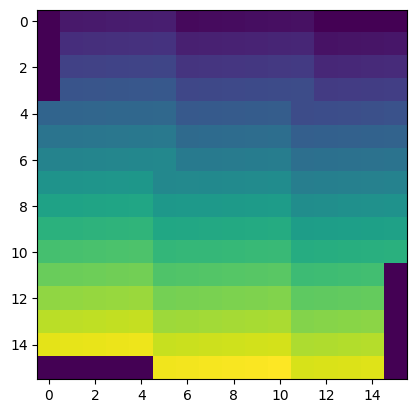

In [64]:
plt.imshow(np.array(map_vector_14).reshape(16, 16)); 

In [ ]:
len(rotated_annots['images'])

In [ ]:
rotated_tiled_img.shape

In [ ]:
!ls ./annotations/f1m/

In [ ]:
plt.imshow(cropped_img);

In [ ]:
!ls images/f1m/

In [ ]:
annots['images'][0]['black_image']

In [ ]:
/home/hkhachatrian/mae/images/f1m

In [ ]:
tmp = cv2.imread('/mnt/lwll/lwll-coral/FAIR1M/fair1m_1000/val1000/images/5239__1__0___0.png')

In [ ]:
plt.imshow(tmp);

In [ ]:
tmp[:, :, 0].shape

In [ ]:
img = cv2.imread(img_path)

rotated_img_tile_new, mapVec = get_rotated_tile(img, 1, 2, 10)

In [ ]:
idx_1 = 100

# plt.imshow(rotated_img_tile_new)

patch_box_rot = get_patch_by_index(idx_1, w=14, tileHW=16)
plot_img_with_box(rotated_img_tile_new, patch_box_rot)

In [ ]:
cropped_img = cv2.imread(cropped_img_path)
if -1 != mapVec[idx_1]:
    patch_box_orig = get_patch_by_index(mapVec[idx_1], w=14, tileHW=16)
    plot_img_with_box(cropped_img, patch_box_orig)

else:
    plt.imshow(cropped_img)
    print(-1)

In [ ]:
M = rotation_matrix(angle, *img.shape[:2])
rotated_img = rotate_image(img, M)

center_x, center_y = rotated_img.shape[0] // 2, rotated_img.shape[1] // 2
new_width, new_height = img.shape[0], img.shape[1]

start_x, start_y = int(center_x - (new_width / 2)), int(center_y - (new_height / 2))

# get_patch_center_coordinates(img.shape[0], img.shape[1], d)

old_centers_patches = get_patch_center_coordinates_subimage([x*224, y*224], [(x+1)*224, (y+1)*224], 224, 16)
 
new_centers_patches = apply_affine_transform(old_centers_patches, M)
new_centers_patches = apply_shift_transform(new_centers_patches, start_x, start_y)

img_dr_red = draw_red_crosses(cropped_img, new_centers_patches)

print(x, y)
# print(new_centers_patches)
plt.imshow(img_dr_red)

plot_img_with_box(img_dr_red, final_box)

In [ ]:
def img_to_coord(tile, x, y):
    x1, y1 = x * tile, y * tile
    x2, y2 = (x+1) * tile, (y+1) * tile
    
    return np.array([x1, y1, x2, y2])

new_coord_ = img_to_coord(224, 1, 2)

In [ ]:
plot_img_with_box(cropped_img, new_coord_)

In [ ]:
plot_img_with_box(img, box_coords)

In [ ]:
def get_new_crop(img, box, resize=False, tile=224):
    if box.size != 4:
        box = np.array([box[0][0], box[0][1], box[2][0], box[2][1]])
        
    new_img = img[box[1]:box[3], box[0]:box[2], :]
    
    if resize:
        new_img = cv2.resize(new_img, (tile, tile), interpolation=cv2.INTER_CUBIC)
        
    return new_img

In [ ]:
# rot_img, rot_coords = rotate_image(img, -2, box_coords)
plot_img_with_box(rotated_img, box)

In [ ]:
def plot_img_with_box(img, box_coords):
    fig, ax = plt.subplots()
    plt.imshow(img)
    if box_coords.size == 4:
        x_min, y_min, x_max, y_max = box_coords
        
        box_coords = np.array([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])
    else:
        x_max, y_max, x_min, y_min = np.array([box_coords[0][0], box_coords[0][1], 
                                               box_coords[2][0], box_coords[2][1]])
        
#     width = x_max - x_min
#     height = y_max - y_min
#     rect = Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    x, y = zip(*box_coords)
    plt.plot(x, y, color='red')
    
#     ax.add_patch(rect)
    plt.show()
    